<img src="images/bannerugentdwengo.png" alt="Banner" style="width: 150px;"/>

<div style='color: #690027;' markdown="1">
    <h1>DEEP LEARNING-MODEL VOOR SENTIMENTANALYSE</h1> 
</div>

<div class="alert alert-box alert-success">
    In deze notebook werk je aan een concrete toepassing van sentimentanalyse. Je maakt gebruik van een dataset van filmreviews om een <em>machine learning</em>-algoritme te trainen dat beslist of een filmreview positief of negatief is.<br>
    Zo'n machine learning-algoritme zoekt in grote hoeveelheden data naar patronen. Op basis van deze patronen kan het algoritme dan een beslissing nemen. 
</div>

In de vorige twee notebooks over sentimentanalyse wordt het sentiment van een review bepaald aan de hand van gekende patronen (de polariteiten van de woorden in de review - deze polariteiten zijn terug te vinden in een lexicon). Op basis van deze polariteiten wordt beslist of een review een positief of negatief sentiment heeft. <br>
In deze notebook gebruik je machine learning om, enkel op basis van een grote dataset met gelabelde reviews, de computer te leren om de polariteit van een review te herkennen. Meer specifiek: je gebruikt een deep learning-model wat een machine learning-model is dat uit aaneengeschakelde lagen bestaat.

### Modules importeren
Naast de gekende modules pandas, NumPy en Matplotlib, gebruikt de code in deze notebook ook de Python-module NLTK, wat staat voor Natural Language Toolkit, en Keras, scikit-learn en Tensorflow om een deep learning-systeem te kunnen opzetten. 

In [1]:
# modules importeren

import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords

import matplotlib.pyplot as plt

import mpld3
mpld3.enable_notebook()
plt.rcParams['figure.figsize'] = [9.5, 6]

from numpy import array
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model

from sentiment_helpers import maak_klaar_voor_voorspelling, train_model, stel_deeplearning_model_op, zet_polariteiten_om_naar_getallen, kuis_dataset_op, maak_staafdiagram_polariteiten, verwerk_invoerdata, verwijder_html, vervang_leestekens, verwijder_enkelvoudige_karakters, verwijder_meervoudige_spaties 

from staafdiagram import maak_staafdiagram_polariteiten

<div style='color: #690027;' markdown="1">
    <h2>1. De dataset</h2> 
</div>

Eerst lees je een dataset van filmreviews in [1].  
Deze dataset bestaat uit een grote tabel met twee kolommen. Op elke rij vind je in de eerste kolom de tekst van de review terug, en in de tweede kolom staat of die review positief of negatief is (het sentiment). 

In [2]:
# Lees dataset in uit een csv-bestand
reviews = pd.read_csv("data/imdbdataset.csv")

# toon eerste 5 reviews
reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
# omzetten naar NumPy-array
reviews = np.array(reviews)

# toon eerste 10 reviews
print(reviews[0:10])

[["One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the 

Je kent het aantal reviews als je de 'vorm' van de dataset bekijkt. Aan de hand van de volgende instructie kan je het kenmerk `shape` van de Numpy-array opvragen: `reviews.shape`.

In [21]:
print(reviews.shape)

(50000, 2)


De dataset heeft 50 000 rijen en 2 kolommen. Hij bevat dus 50 000 reviews samen met hun overeenkomstige polariteit.

Het is altijd interessant om, voor je begint met het coderen van een machine learning-algoritme, de gebruikte dataset wat meer in detail te bekijken. Bekijk eens een aantal reviews van dichterbij.

In [23]:
# toon tekst van 1025ste review
print("Review 1025:")
print(reviews[1024, 0])      # eerste kolom van review met index 1024

Review 1025:
This is a good time to say how good I think of this site: it gives me the opportunity to feedback all the frustration I lived for two hours, awaiting for something to happens, for something to be said, to be shown, to be insinuated subtly, for a symbol, an idea, whatever. No, just long, endless violins, alternated by a tired piano. Tired voices, tired actors and bored characters and situations. Boring is the long death of the mind, and this movie is, from that point of view, a public enemy. How many thousands of live hours will be still stolen to another thousands of innocent spectators. I don't claim for my money back, just for my time and the time of persons I invited to watch this thing... oh God !


In [24]:
# toon tekst van 2049ste review
print("Review 2049:")
print(reviews[2048, 0])

Review 2049:
I have always loved The Muppets. Though most children's entertainment then wasn't that likable, The Muppet's was. The Muppet's are very, very funny. They are probably the most likable children's characters ever. <br /><br />Not only did The Muppets have their own show. They also have starred in many films. from The Muppet's Christmas carol to The Muppet's treasure Island. The first Muppet's movie, The Muppet movie, was also, like the show and the other films, excellent.<br /><br />The Muppet movie is about how they all got started. Kermit the frog used to live in a swamp. Until one day a movie executive tells him that there are auditions for frogs in Hollywood. So Kermit takes off for Hollywood. Along the way he runs into lots of people such as Fozzie Bear, Gonzo the great, and Miss Piggy. Also, an evil man is trying to capture Kermit.<br /><br />All of the Muppet films are highly enjoyable. I mean they are all very funny. This film has many film appearances. Such as Steve

### Opdracht 1.1
- Lees bovenstaande reviews grondig door. 
- Kan jij van beide reviews bepalen of het sentiment positief of negatief is?

In [25]:
# toon sentiment van reviews met indices 1024 en 2048
print("Sentiment van review 1025: ", reviews[1024, 1])               # tweede kolom van review met index 1024
print("Sentiment van review 2049: ", reviews[2048, 1])

Sentiment van review 1025:  negative
Sentiment van review 2049:  positive


- Komt jouw idee overeen met wat gegeven is in de dataset?

Bij machine learning is het belangrijk dat de dataset waarmee je werkt min of meer gebalanceerd is. Dit wil zeggen dat je ongeveer evenveel voorbeelden met een positief als een negatief sentiment moet hebben.<br>
Je kan de verdeling makkelijk visualiseren aan de hand van de volgende code:

In [4]:
# bekijk welke verschillende polariteiten in dataset voorkomen en tel hoeveel keer
polariteiten, frequenties = np.unique(reviews[:,1], return_counts=True)  
print(polariteiten, frequenties)

# toon hoeveel keer elk label voorkomt
print("Polariteit " + "'" + str(polariteiten[0]) + "'" + " komt " + str(frequenties[0]) + " keer voor.")
print("Polariteit " + "'" + str(polariteiten[1]) + "'" + " komt " + str(frequenties[1]) + " keer voor.")

['negative' 'positive'] [25000 25000]
Polariteit 'negative' komt 25000 keer voor.
Polariteit 'positive' komt 25000 keer voor.


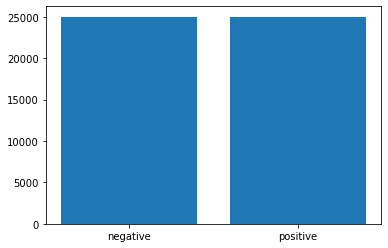

In [6]:
# visualiseer verdeling in staafdiagram
maak_staafdiagram_polariteiten(polariteiten, frequenties)

Je ziet dat de dataset perfect gebalanceerd is.

<div style='color: #690027;' markdown="1">
    <h2>2. De data voorverwerken</h2> 
</div>

### Preprocessing

<div class="alert alert-box alert-info">
Zoals je hiervoor kon zien, staan er in sommige reviews vreemde codetags zoals <span style="background-color:whitesmoke; font-family:consolas; font-size:1em;">br /</span>. Dit komt omdat de reviews vanuit de broncode van een HTML-pagina gekinpt zijn. Voor je het algoritme kan trainen, moet je deze tags eerst verwijderen. 
</div>    

In [7]:
# volgende functie past opkuisregels toe op gegeven tekst
def tekst_opschonen(tekst):
    tekst = verwijder_html(tekst)                        # verwijder alle HTML-elementen uit tekst
    tekst = vervang_leestekens(tekst)                    # vervang alle leestekens door spaties
    tekst = verwijder_enkelvoudige_karakters(tekst)      # verwijder alle enkelvoudige letters
    propere_tekst = verwijder_meervoudige_spaties(tekst) # vervang meervoudige spaties door één spatie
    return propere_tekst

We kunnen nu de tekst van een review opkuisen door de `tekst_opschonen()`-functie toe te passen op een van de reviews. De code hieronder toont de opgekuiste versie van de review met index 2048. Zie je het verschil met hoe de tekst van die review er hierboven uitzag?

In [8]:
# toon opgeschoonde tekst van review met index 2048
print(tekst_opschonen(reviews[2048, 0]))

NameError: name 'verwijder_html' is not defined

Nu je over een functie beschikt om ongewenste tekens uit de reviews te verwijderen, kan je die toepassen op de dataset. De volgende code kuist alle reviews in de dataset op. Deze code is niet zo eenvoudig om te begrijpen. Staar jezelf er dus niet blind op.

In [10]:
# pas opkuisfunctie toe op elke review in dataset
reviews[:, 0] = kuis_dataset_op(reviews)            # teksten staan in eerste kolom van 'reviews'

Controleer of dit gelukt is door nog eens naar de tekst van de 2049ste review te kijken:

In [11]:
# Druk de tekst van review 2048 nog eens af.
print('Review 2048:')
print(reviews[2048, 0])

Review 2048:
I have always loved The Muppets Though most children entertainment then wasn that likable The Muppet was The Muppet are very very funny They are probably the most likable children characters ever Not only did The Muppets have their own show They also have starred in many films from The Muppet Christmas carol to The Muppet treasure Island The first Muppet movie The Muppet movie was also like the show and the other films excellent The Muppet movie is about how they all got started Kermit the frog used to live in swamp Until one day movie executive tells him that there are auditions for frogs in Hollywood So Kermit takes off for Hollywood Along the way he runs into lots of people such as Fozzie Bear Gonzo the great and Miss Piggy Also an evil man is trying to capture Kermit All of the Muppet films are highly enjoyable mean they are all very funny This film has many film appearances Such as Steve Martin Mel Brooks Elliot Gould Carol Kane Richard Pryor and Orson Welles The Mupp

In [9]:
print(reviews[2048, 1])

positive


Het label is ongewijzigd. 

De tekst van de reviews staat nu in een formaat dat je kan gebruiken voor het <em>machine learning-</em> algoritme. Je moet wel de polariteiten nog omzetten naar een formaat dat het algoritme begrijpt. Het algoritme stelt de uitvoerwaarden altijd voor als getallen. Bijgevolg moet je de polariteiten 'positive' en 'negative' die in de dataset voorkomen, omzetten naar getallen. <br>Onderstaande code zet 'positive' om in een 1 en 'negative' in 0. 

In [10]:
# verander 'positive' naar 1 en 'negative' naar 0
reviews[:, 1] = zet_polariteiten_om_naar_getallen(reviews)

NameError: name 'zet_polariteiten_om_naar_getallen' is not defined

Controleer nog eens de labels van de reviews met indices 1024 en 2048. Dit zouden nu getallen moeten zijn in plaats van tekst.

In [11]:
print("Sentiment van review 1024: ", reviews[1024, 1])
print("Sentiment van review 2048: ", reviews[2048, 1])

Sentiment van review 1024:  negative
Sentiment van review 2048:  positive


Zo, nu staat de dataset in de vorm die nodig is om het <em>machine learning-</em> algoritme te trainen. In het volgende deel bekijk je meer in detail hoe het algoritme werkt en hoe je het kan gebruiken om aan sentimentanalyse te doen.

<div style='color: #690027;' markdown="1">
    <h2>3. Machine learning</h2> 
</div>

<div style='color: #690027;' markdown="1">
    <h3>3.1 De train- en validatieverzameling</h3> 
</div>

Machine learning, ofwel machinaal leren (ML) maakt gebruik van algoritmes die, op basis van grote hoeveelheden data, patronen kunnen herkennen en op basis van die patronen beslissingen nemen. <br>
Om deze algoritmes efficiënt te trainen gvertrek je best van een dataset die uit twee onderdelen bestaat: een <b>trainingsset</b> en een <b>validatieset</b>. Deze twee verzamelingen zijn beide een deelverzameling van de volledige dataset, en ze zijn disjunt. Gewoonlijk bevat de trainingsset meer data dan de validatieset.<br>
Hieronder vind je meer info over de twee verzamelingen:

<ul>
    <li>Op basis van de <b>trainingsset</b> zoekt het algoritme naar patronen die informatie geven over wat je wil voorspellen, het algoritme 'leert' dus zelfstandig patronen herkennen. Mogelijke patronen zijn bijvoorbeeld het aantal letters in de tekst, het aantal lidwoorden in de tekst maar bijvoorbeeld ook of bepaalde woorden, zoals 'fun' of 'hate', al dan niet voorkomen. Sommige patronen, bv. het aantal keer dat het woord 'fun' voorkomt, zeggen meer over de polariteit dan andere, zoals het aantal keer dat de letter 'e' in de tekst staat. Het algoritme zoekt de patronen die het best gebruikt kunnen worden om het sentiment te voorspellen.</li>
    <li>De <b>validatieset</b> test of het algoritme ook het sentiment van reviews kan voorspellen die het nog niet eerder gezien heeft tijdens het leerproces. Dit is nodig omdat je bijvoorbeeld niet wil dat het algoritme de dataset gewoon 'uit het hoofd' leert. Met andere woorden: je wil niet dat het algoritme gewoon weet dat de exacte tekst van de review met index 2048 positief is zonder patronen te herkennen in de tekst. Als je in dat geval één letter zou veranderen in de tekst zal het algoritme niet meer in staat zijn om een correcte voorspelling te doen.</li>
</ul>

Voor deze toepassing splits je de dataset op in een trainingsset die 80 % van de reviews bevat en een validatieset die bestaat uit de overige 20%.

<div>
    Naast de opsplitsing in trainings- en testverzameling, beschouw je ook de reviewteksten (X_...) apart van de labels (y_...).<br>
Hieronder zie je een visuele weergave van de splitsing:
<img src="images/ChatbotSentiment/train_test_split.svg" alt="Banner" align="center" style="width:900px;"/>
</div>

De volgende code splitst de data op:

In [12]:
# splitst dataset in trainingsset en validatieset
X_train, X_val, y_train, y_val = train_test_split(reviews[:,0], reviews[:,1], test_size=0.20, random_state=31)

NameError: name 'train_test_split' is not defined

Omdat het *machine learning*-algoritme niet goed om kan met een trainingsverzameling waarbij de elementen een verschillende lengte hebben (een verschillend aantal woorden), worden de invoerdata nog een beetje anders gestructureerd.<br>
Om dit te doen leg je vast:
- hoeveel verschillende woorden in alle reviews mogen voorkomen;
- hoeveel woorden een review maximum mag hebben. 
Op basis van deze twee waarden pas je de reviews aan:
- Behoud telkens de 5000 meest voorkomende woorden en verwijder alle andere woorden uit de reviews.
- Ga voor elke review na hoeveel woorden die nog bevat. 
- Bevat de review minder dan 100 woorden, dan behoud je alle woorden; bevat deze meer dan 100 woorden, dan verwijder je de laatse woorden van de review.

In [15]:
maximum_aantal_woorden = 5000
maximum_lengte_zin = 100
X_train, X_val, y_train, y_val = verwerk_invoerdata(X_train, X_val, y_train, y_val, maxlen=maximum_lengte_zin, maxwords=maximum_aantal_woorden)

<div style='color: #690027;' markdown="1">
    <h3>3.2 Het deep learning-model</h3> 
</div>

De data zijn nu volledig klaar om als invoer te dienen voor een <em>machine learning</em>-algoritme. Het gebruikte algoritme valt onder de categorie van de <em>diepe neurale netwerken</em>. <em>Diepe neurale netwerken</em> bestaan uit verschillende lagen, elk van deze lagen voert een bewerking uit op de uikomst van de vorige laag. Het model datje hier gebruikt, bestaat uit drie lagen:

<ol>
    <li>De eerste laag heeft als doel om gelijksoortige woorden om te zetten naar gelijksoortige eigenschappen. Voorbeelden van mogelijke eigenschappen zijn: het aantal letters in het woord, het aantal drukletters in het woord, of het aantal keer dat de letter 'e' voorkomt. 
        Als je deze omzetting naar eigenschappen toepast op een aantal eenvoudige woorden krijg je het volgende resultaat:
        <ul>
            <li>'het' -> 'aantal letters': 3, 'aantal drukletters': 0, 'aantal keer letter e': 1</li>
            <li>'CARNAVALSOPTOCHT' -> 'aantal letters': 16, 'aantal drukletters': 16, 'aantal keer letter e': 0</li>
            <li>'een' -> 'aantal letters': 3, 'aantal drukletters': 0, 'aantal keer letter e': 2</li>
        </ul>
        Dit voorbeeld laat duidelijk zien dat de woorden 'het' en 'een' meer gelijksoortige eigenschappen hebben dan de woorden 'het' en 'CARNAVALSOPTOCHT'. Dit voorbeeld illustreert het principe maar <strong>in de praktijk weten we niet welke eigenschappen de eerste laag juist zal gebruiken</strong>. Het algoritme zal leren om de eigenschappen te kiezen die het meeste informatie geven over het sentiment van het woord.
    </li>
    <li>De tweede laag voegt voor elke review de eigenschappen uit de eerste laag samen tot een groep van eigenschappen voor de volledige zin. Als de zin 'een CARNAVALSOPTOCHT' zou zijn dan is het resultaat van de tweede laag: 3, 0, 2, 16, 16, 0. </li>
    <li>De laatste laag vormt het resultaat van de de tweede laag om naar een sentimentwaarde. De regels die de laag hiervoor gebruikt leert het op basis van de data. In dit eenvoudig voorbeeld zou de laag bijvoorbeeld geleerd kunnen hebben dat hoe hoger het aandeel aan drukletters in de zin is, hoe positiever het sentiment is. Omdat er 16 van de 19 letters in de zin drukletters zijn, zou de laag dus de waarde 1 (positief) als uitvoerwaarde geven. <strong>Hier weet je in de praktijk opnieuw niet welke regels de laag juist zal hanteren.</strong></li> 
</ol>

De volgende code stelt het model op dat hierboven is beschreven. 

In [22]:
# stel model op dat hierboven beschreven staat
model = stel_deeplearning_model_op(maximum_aantal_woorden)

In een samenvatting van het model kan je de verschillende lagen zien.

In [17]:
# model samenvatten
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Omzetting_woord_naar_eigensc (None, 100, 100)          500000    
_________________________________________________________________
Samenvoegen_eigenschappen_zi (None, 10000)             0         
_________________________________________________________________
Voorspellen_sentiment (Dense (None, 1)                 10001     
Total params: 510,001
Trainable params: 510,001
Non-trainable params: 0
_________________________________________________________________


Je kan ook een visuele weergave van het model laten zien (zie onderstaande figuur). <br>
Merk op dat er hier vier lagen worden getoond. De eerste laag is eigenlijk geen echte laag maar gewoon de invoer van de data.
Deze invoer komt overeen met de gelabelde tekst van een review.

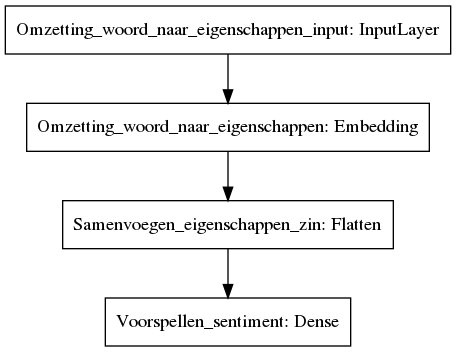

In [18]:
# visuele weergave van model
plot_model(model, to_file='model_plot.png', show_shapes=False, show_layer_names=True)

<div style='color: #690027;' markdown="1">
    <h3>3.3 Het model trainen</h3> 
</div>

Zoals hierboven beschreven vormen de lagen een review stap voor stap om tot een sentimentwaarde. Op dit moment weet ons model echter nog totaal niet hoe het deze omzetting moet doen. Net als een mens leert het algoritme door voorbeelden van positief en negatief gelabelde reviews te zien te krijgen. Op basis van deze voorbeelden leert het algoritme bij. Eveneens analoog als bij de mens is het nodig om dit leerproces een aantal keer te herhalen om meer en meer patronen te leren zien in de voorbeelden.

Concreet verloopt het leerproces min of meer als volgt:
<ol>
    <li>Neem de tekst van een review.</li>
    <li>Geef de tekst in als invoer aan het algoritme.</li>
    <li>Laat het algoritme een voorspelling doen van het sentiment. (In het begin heeft het algoritme nog niets van kennis dus zal het in elke laag een aantal willekeurige eigenschappen kiezen en op basis daarvan het sentiment gokken.)
        <ul>
            <li>Als het algoritme juist gokt zal het de eigenschappen die het in de verschillende lagen gekozen had, onthouden, zodat het de volgende keer gelijkaardige keuzes zal maken.</li>
            <li>Als het algoritme fout gokt, dan vergeet het de eigenschappen die het in de verschillende lagen gekozen had, zodat die in de toekomst minder kans hebben om gekozen te worden.</li>
        </ul>
    </li>
    <li>Zolang er nog reviews zijn die je niet als invoer hebt genomen, neem je de tekst van een andere review en ga je terug naar stap 2.</li>
</ol>

Deze stappen worden meestal een aantal keer herhaalt om zo tot een nog beter resultaat te komen. Bij het trainen van het algoritme zal je deze stappen 5 keer herhalen. Je zal merken dat dit niet zo snel gaat, de computer moet immers alle 50000 reviews tonen aan het model om het te laten bijleren.

In [19]:
# Leer het model om de eigenschappen te kiezen die het best het sentiment voorspellen.
train_model(model, X_train, y_train, X_test, y_test)

Epoch 1/5
1250/1250 [==============================] - 10s 8ms/step - loss: 0.5137 - accuracy: 0.7318 - val_loss: 0.3398 - val_accuracy: 0.8528
Epoch 2/5
1250/1250 [==============================] - 9s 8ms/step - loss: 0.2382 - accuracy: 0.9066 - val_loss: 0.3560 - val_accuracy: 0.8470
Epoch 3/5
1250/1250 [==============================] - 10s 8ms/step - loss: 0.0875 - accuracy: 0.9841 - val_loss: 0.4132 - val_accuracy: 0.8416
Epoch 4/5
1250/1250 [==============================] - 9s 8ms/step - loss: 0.0225 - accuracy: 0.9992 - val_loss: 0.4724 - val_accuracy: 0.8417
Epoch 5/5
1250/1250 [==============================] - 10s 8ms/step - loss: 0.0079 - accuracy: 0.9998 - val_loss: 0.5278 - val_accuracy: 0.8437


Je ziet dat het algoritme een <em>val_accuracy</em> heeft van ongeveer 0.84. Dit wil zeggen dat het voor 84 % van de reviews het sentiment correct kan voorspellen. Dit wil dus ook zeggen dat het een foute voorspelling zal geven voor 16 % van de reviews.

<div style='color: #690027;' markdown="1">
    <h3>3.4 Het model gebruiken</h3> 
</div>

Nu het model geleerd heeft om het sentiment van reviews te voorspellen, kan je het gebruiken om het sentiment van een willekeurige review te voorspellen. Hieronder zie je recente reviews die vanop rottentomatoes.com geplukt zijn. Na het opschonen van deen review kan je het algoritme er een voorspelling voor laten doen.

In [20]:
review_godzilla_vs_kong = "Godzilla vs. Kong spends more time with King Kong in his journey to Hollow Earth. King Kong in the Antarctic snow is a beautiful image, and there are other fun images in Hollow Earth. This is the third movie to minimize Godzilla though. It was the whole gimmick of the 2014 Godzilla to hide him, and King of the Monsters sidelined him too. In his story, King Kong has a relationship with Jia (Kaylee Hottle) who communicates with him via sign language. Their relationship is going for a Spielbergian child and creature vibe. It may be missing a few beats but it’s sincere."
review_godizlla_vs_kong = maak_klaar_voor_voorspelling(review_godzilla_vs_kong, maximum_lengte_zin)
voorspelling = model.predict(review_godizlla_vs_kong)[0, 0]

print(f"De voorspelde polariteit van de review is {voorspelling * 2 - 1}.")

if voorspelling > 0.55:
    print("De review is positief.")
elif voorspelling < 0.45:
    print("De review is negatief.")
else:
    print("De review is neutraal.")

De voorspelde polariteit van de review is 0.963327169418335
De review is positief.


Merk op dat het algoritme een waarde geeft tussen 0 en 1. Door de code `voorspelling * 2 - 1` wordt deze waarde omgezet naar een sentimentwaarde tussen -1 en 1.

In [21]:
review_cherry = "But perhaps Cherry’s most baffling choice is to have both a voiceover narration and direct fourth wall breaks with Holland directly addressing the viewer. There’s no consistency on why it chooses one over the other at any given time and it never justifies why it’s doing either. All that serves to drag down a movie that feels like it’ll never end."
review_cherry = maak_klaar_voor_voorspelling(review_cherry, maximum_lengte_zin)
voorspelling = model.predict(review_cherry)[0, 0]

print(f"De voorspelde polariteit van de review is {voorspelling*2 - 1}.")

if voorspelling > 0.55:
    print("De review is positief.")
elif voorspelling < 0.45:
    print("De review is negatief.")
else:
    print("De review is neutraal.")

De voorspelde polariteit van de review is -0.9256005883216858
De review is negatief.


### Opdracht
- Ga op zoek naar een review op het internet (dat kan bijvoorbeeld op www.rottentomatoes.com). 
- Plak de tekst hier in de string met naam `eigen_review`. 
- Controleer of het model het sentiment van de review correct kan voorspellen. Denk eraan dat het algoritme enkel de eerste 100 woorden van de review gebruikt. Je zal dus mogelijk maar een deel van een review als input kunnen geven.

In [26]:
eigen_review = ""
eigen_review = maak_klaar_voor_voorspelling(eigen_review, maximum_lengte_zin)
voorspelling = model.predict(eigen_review)[0, 0]

print(f"De voorspelde polariteit van de review is {voorspelling*2 - 1}.")

if voorspelling > 0.55:
    print("De review is positief.")
elif voorspelling < 0.45:
    print("De review is negatief.")
else:
    print("De review is neutraal.")

De voorspelde polariteit van de review is 0.020172119140625
De review is neutraal.


### Referentielijst

[1] Kaggle. IMDB Dataset of 50K Movie Reviews  Dataset. https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

<img src="images/cclic.png" alt="Banner" align="left" style="width:100px;"/><br><br>
Notebook Chatbot, zie <a href="http://www.aiopschool.be">AI Op School</a>, van T. Neutens, F. wyffels, & N. Gesquière is in licentie gegeven volgens een <a href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Naamsvermelding-NietCommercieel-GelijkDelen 4.0 Internationaal-licentie</a>.